# In this notebook:

* Load graph

In [1]:
from graph_tool.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import json

/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/powerenv/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


## Load graph and pos2node

In [2]:
base_path = "../outputs/path_92699"

In [3]:
pos2node = np.load(base_path+"_pos2node.npy")

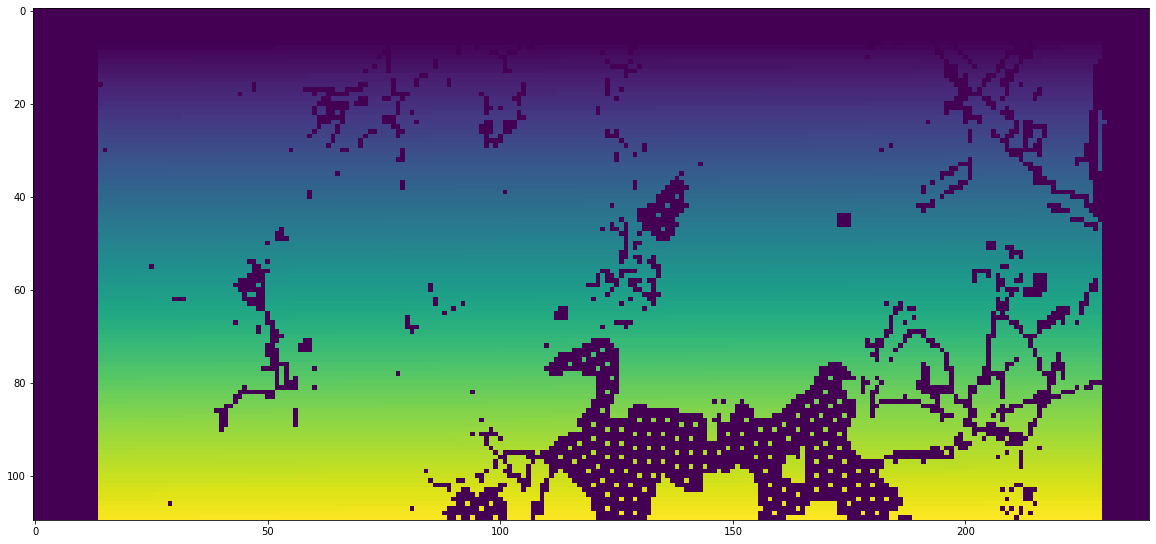

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(pos2node[70:180, 10:250])
plt.show()

In [52]:
# load graph itself
graph = load_graph(base_path + "_graph.xml.gz")

In [54]:
all_costs = graph.ep.weight
cost_props = list()
classes = ["env", "urban"]
for props in classes:
    cost_props.append(eval("graph.ep."+props))

In [7]:
# test: all costs if combination of others
print(cost_props[0].get_array()[10], cost_props[1].get_array()[10], all_costs.get_array()[10])

0.4 0.3580952380952381 0.2526984126984127


In [8]:
0.333333*0.4 + 0.333333*0.35

0.24999975000000002

In [9]:
# load infos
with open(base_path+"_infos.json", "r") as infile:
    infos_path = json.load(infile)

In [10]:
## beginning: 5 293 756 edges
# start cells: [408  62] dest cells: [235 601]        
source = 16749 # 58730 
dest = 3557 # 12160

## Randomly delete edges:

In [11]:
def remove_edges(graph, remove_percent = 0.3):
    n_edges = len(list(graph.edges()))
    print("prev number edges", n_edges)
    remove_ind = int(n_edges * remove_percent)
    print("removing ", remove_ind, "edges")
    remove = np.random.permutation(np.arange(n_edges))[:remove_ind]
    remove_arr = np.zeros(n_edges)
    remove_arr[remove] = 1
    # del graph.properties[("e", "remove_property")]
    remove_property = graph.new_edge_property("float")
    remove_property.a = remove_arr
    remove_labeled_edges(graph, remove_property)
    print("now number edges:", len(list(graph.edges())))

In [12]:
remove_edges(graph, remove_percent = 0.5)

prev number edges 483010
removing  241505 edges
now number edges: 241505


In [ ]:
# USE SET FILTERS FUNCTION
# set_filters(self, eprop, vprop, inverted_edges=False, inverted_vertices=False)[source]¶

In [35]:
# To also reduce property maps
keep = np.abs(1-remove_arr)
arr = all_costs.get_array()
arr_keep = arr*keep
print(len(arr_keep))
arr_keep = arr_keep[arr_keep>0]
print(len(arr_keep))

483010
338107


In [80]:
# edges = graph.get_edges()
# v1, v2 = edges[2000]
all_costs[graph.edge(graph.vertex(v1), graph.vertex(v2))]

0.32381886087768436

In [53]:
edges = graph.get_edges()
v1, v2 = edges[2000]
print(v1,v2)
all_costs[graph.edge(graph.vertex(v1), graph.vertex(v2))]

163 366


0.32381886087768436

In [24]:
print("average path costs for original:", np.mean(np.asarray(infos_path["edgecosts"]), axis=0))
# not equal to costs computed here weil edge costs vs node costs

average path costs for original: [0.38807622 0.36841572]


### Compute probability that edges are kept

In [142]:
m = 483010 # n_edges
k = 50 # length of path
p = 0.005 # probability remove
def prob_kept(m,k,p):
    n_rem = int(m*p)
    print(m-k, m, n_rem)
    # prob = binom(m-k, n_rem) / binom(m, n_rem) # number of sets to draw with 
    zaehler = np.arange(m-n_rem, m-n_rem-k, -1)
    nenner = np.arange(m,m-k, -1)
    prob = np.product(zaehler/nenner)
    print("probability to keep the shortest path edges", prob)
    return prob
_ = prob_kept(m,k,p)

482960 483010 2415
probability to keep the shortest path edges 0.7783066860127305


### Baseline path: path without weights

In [143]:
vertices_path, edges_path = get_path(graph_red, None)
path, path_costs = convert_path(graph_red, vertices_path, edges_path, pos2node)

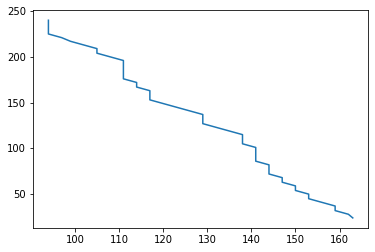

Baseline path: length: 49 costs: [20.81543491 21.88372622]


In [150]:
path = np.asarray(path)
plt.plot(path[:,0], path[:,1])
plt.show()
print("Baseline path:", "length:", len(path), "costs:", np.sum(path_costs,axis=0))

### Remove edges and compute path

In [136]:
# same procedure as for pareto fronteir, just vary the number of removed edges instead
rem = np.logspace(-5, -1, 10, base=3)
print(rem)
pareto = []
paths = list()
for r in rem:
    if r==0:
        graph_red = graph
    else:
        graph_red = graph.copy()
        remove_edges(graph_red, remove_percent = r)
    all_costs = graph_red.ep.weight
    vertices_path, edges_path = get_path(graph_red, all_costs)
    path, path_costs = convert_path(graph_red, vertices_path, edges_path, pos2node)
    print("removed:", r, "cost sum", np.sum(path_costs, axis=0), "path length", len(path))
    pareto.append(np.sum(path_costs, axis=0))
    paths.append(path)

[0.00411523 0.00670575 0.01092701 0.01780555 0.02901411 0.04727844
 0.07704014 0.12553677 0.20456195 0.33333333]
prev number edges 483010
removing  1987 edges
now number edges: 481023
removed: 0.00411522633744856 cost sum 0.0 path length 50
prev number edges 483010
removing  3238 edges
now number edges: 479772
removed: 0.006705754000900604 cost sum 0.0 path length 50
prev number edges 483010
removing  5277 edges
now number edges: 477733
removed: 0.010927014223104452 cost sum 0.0 path length 50
prev number edges 483010
removing  8600 edges
now number edges: 474410
removed: 0.01780555025070874 cost sum 0.0 path length 51
prev number edges 483010
removing  14014 edges
now number edges: 468996
removed: 0.029014112479158232 cost sum 0.0 path length 51
prev number edges 483010
removing  22835 edges
now number edges: 460175
removed: 0.04727844470404599 cost sum 0.0 path length 51
prev number edges 483010
removing  37211 edges
now number edges: 445799
removed: 0.07704014159451496 cost sum 0.0 

## All shortest paths:
* all_paths function of graph-tool does DFS --> not useful
* all_shortest_paths of graph-tool returns only the unique single path in our case

### Round edge costs --> more shortest paths 

In [85]:
costs_rounded = graph.new_edge_property("int")
costs_rounded.a = (cost_props[0].get_array()*10).astype(int)

In [90]:
max_paths = 100
paths = []
rem = []
for i,vertices_path in enumerate(all_shortest_paths(graph, graph.vertex(source),
                    graph.vertex(dest), weights=costs_rounded,
                    negative_weights=True)):
    rem.append(i)
    # edges_path = []
    path, _ = convert_path(graph, vertices_path, [], pos2node)
    paths.append(path)
    if i>max_paths:
        break
print("number of paths:", i)

number of paths: 101


## Shortest path

In [137]:
def get_path(graph, all_costs):
    vertices_path, edges_path = shortest_path(
                    graph,
                    graph.vertex(source),
                    graph.vertex(dest),
                    weights=all_costs,
                    negative_weights=True
                )
    return vertices_path, edges_path
def convert_path(graph, vertices_path, edges_path, pos2node):
    path = []
    for v in vertices_path:
        pos_x, pos_y = np.where(pos2node==graph.vertex_index[v])
        assert len(pos_x)==1, "posx{}".format(pos_x)
        path.append([pos_x[0], pos_y[0]])

    path_costs = []
    for e in edges_path:
        costs = [props[e] for props in cost_props]
        path_costs.append(costs)
    return path, path_costs

In [14]:
len(all_costs.get_array())

483010

In [15]:
path, path_costs = get_path(graph, all_costs, pos2node)

In [16]:
path_orig = infos_path["path_cells"]

In [17]:
len(path_orig)

50

## Pareto frontier

In [152]:
rem = np.arange(0,1.1, 0.1)
pareto = []
paths = list()
all_costs = graph.ep.weight
for w in rem:
    all_costs.a = cost_props[0].get_array()*w + cost_props[1].get_array() * (1-w)
    vertices_path, edges_path = get_path(graph, all_costs)
    path, path_costs = convert_path(graph, vertices_path, edges_path, pos2node)
    print(w, 1-w, np.sum(path_costs, axis=0))
    pareto.append(np.sum(path_costs, axis=0))
    paths.append(path)

0.0 1.0 [21.71425844 16.47612717]
0.1 0.9 [21.38955255 16.48565098]
0.2 0.8 [20.82484667 16.61136527]
0.30000000000000004 0.7 [20.41190549 16.73517479]
0.4 0.6 [20.28249373 16.80756375]
0.5 0.5 [19.02484667 17.94658337]
0.6000000000000001 0.3999999999999999 [18.99072902 17.98848813]
0.7000000000000001 0.29999999999999993 [18.49661138 18.85325003]
0.8 0.19999999999999996 [18.36249373 19.28563098]
0.9 0.09999999999999998 [18.12837608 20.35610717]
1.0 0.0 [18.12837608 20.37325003]


No handles with labels found to put in legend.


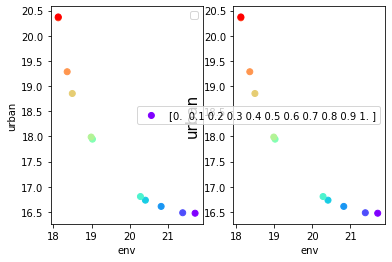

In [232]:
pareto = np.asarray(pareto)
color=plt.cm.rainbow(np.linspace(0,1,len(pareto)))
plt.subplot(1,2,1)
plt.scatter(pareto[:,0], pareto[:,1], c=color)
plt.xlabel(classes[0])
plt.ylabel(classes[1])
plt.legend()

plt.subplot(1,2,2)
plt.scatter(pareto[:,0], pareto[:,1], label=rem, c=color)
plt.xlabel(classes[0])
plt.ylabel(classes[1], fontsize=15)
plt.legend()
plt.show()

In [118]:
e = find_edge(graph, graph.edge_index, 33)
all_costs[e[0]]

0.2596638655462185

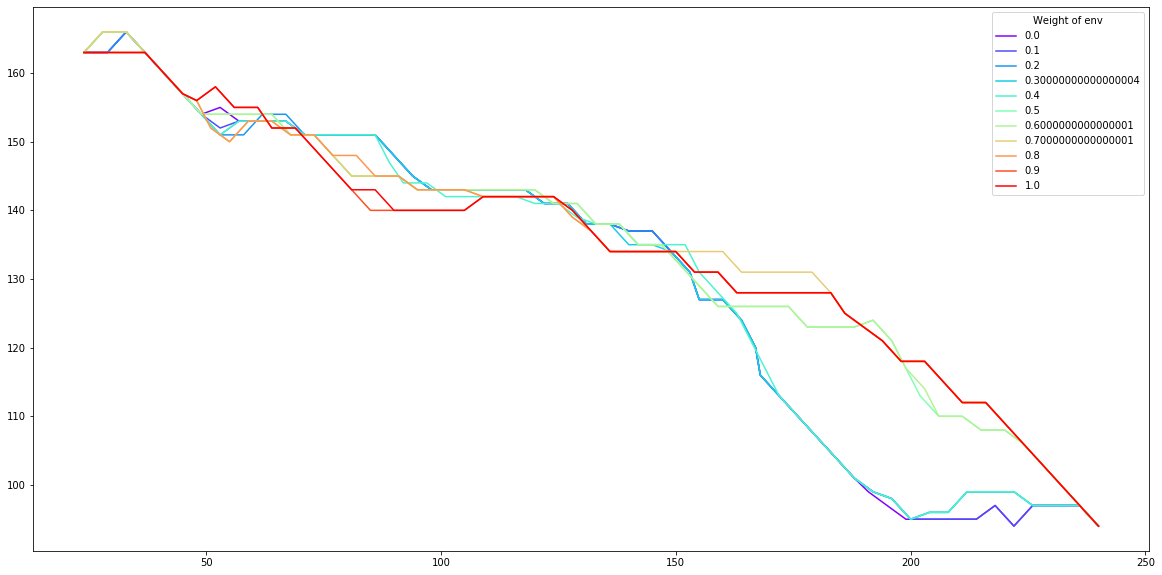

In [226]:
color=iter(plt.cm.rainbow(np.linspace(0,1,len(paths))))
plt.figure(figsize=(20,10))
for i,p in enumerate(paths):
    p_arr = np.array(p)
    c = next(color)
    plt.plot(p_arr[:,1], p_arr[:,0], label = rem[i], c=c)
    # print("path length:", len(p))
plt.legend( title="Weight of "+classes[0]+"costs")
plt.savefig("dropout_path.png")
plt.show()

## Path to distance corridor

In [220]:
from power_planner.utils import bresenham_line
from scipy.ndimage.morphology import binary_dilation
from scipy.spatial.distance import cdist
import time

In [206]:
def get_path_lines(cost_shape, paths):
    path_dilation = np.zeros(cost_shape)
    for path in paths:
        # iterate over path nodes
        for i in range(len(path)-1):
            line = bresenham_line(*path[i], *path[i+1])
            # print(line)
            for (j,k) in line:
                path_dilation[j,k] = 1
    return path_dilation

In [217]:
def dilation_dist(path_dilation):
    """
    path_dilation: binary array with zeros everywhere except for path locations
    """
    saved_arrs = [path_dilation]
    # compute number of iterations: maximum distance of pixel to line
    x_coords, y_coords = np.where(path_dilation)
    x_len, y_len = path_dilation.shape
    # print([np.min(x_coords), x_len- np.max(x_coords), np.min(y_coords), y_len- np.max(y_coords)])
    n_iters = max([np.min(x_coords), x_len- np.max(x_coords), np.min(y_coords), y_len- np.max(y_coords)])
    # dilate
    for k in range(n_iters):
        path_dilation = binary_dilation(path_dilation)
        saved_arrs.append(path_dilation)
    saved_arrs = np.sum(np.array(saved_arrs), axis=0)
    return saved_arrs

In [218]:
def cdist_dist(path_dilation):
    saved_arrs = np.zeros(path_dilation.shape)
    x_len, y_len = path_dilation.shape
    xa = np.array([[i,j] for i in range(x_len) for j in range(y_len)])
    xb = np.swapaxes(np.vstack(np.where(path_dilation>0)),1,0)
    print(xa.shape, xb.shape)
    all_dists = cdist(xa,xb)
    print(all_dists.shape)
    out = np.min(all_dists, axis = 1)
    k=0
    for i in range(x_len):
        for j in range(y_len):
            saved_arrs[i,j] = out[k]
            k+=1
    return saved_arrs

In [234]:
path_dilation = get_path_lines(pos2node.shape, paths)
tic = time.time()
saved_arrs = dilation_dist(path_dilation)
print("time dilation:",time.time()-tic)

[94, 136, 24, 22]
time dilation: 0.36892080307006836


In [224]:
tic = time.time()
saved_arrs = cdist_dist(path_dilation)
print("time cdist:",time.time()-tic)

(79124, 2) (684, 2)
(79124, 684)
time cdist: 0.7996978759765625


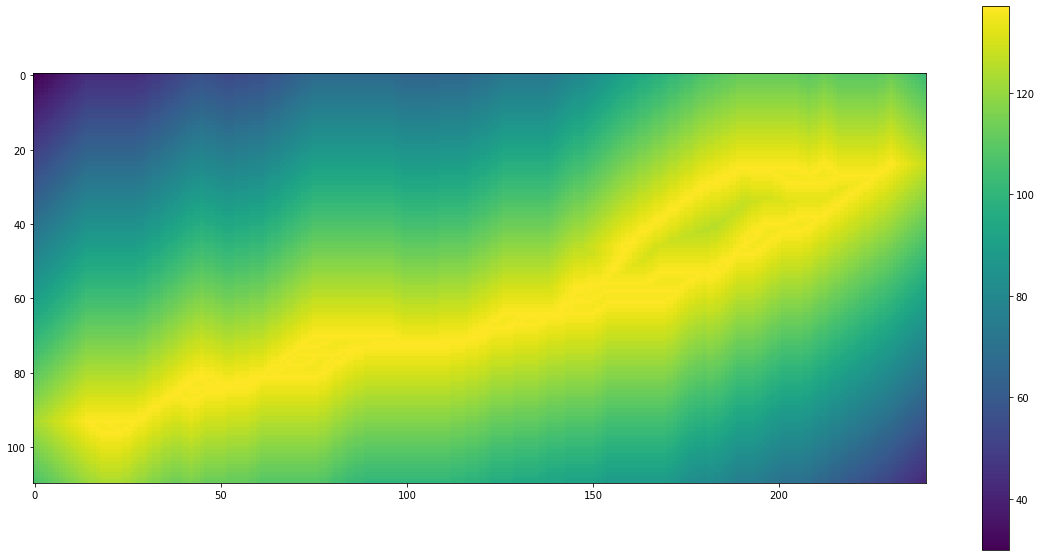

In [235]:
plt.figure(figsize=(20,10))
plt.imshow(saved_arrs[70:180, 10:250])
plt.colorbar()
plt.show()

# Tests

In [ ]:
# make sure that edge costs are just the nodecosts means
edgecosts= np.asarray(infos_path["edgecosts"])
for p in range(len(path_costs)-1):
    costmean = edgecosts[p] + edgecosts[p+1]
    print(path_costs[p], 0.5*costmean)

In [26]:
print(infos_path["path_cells"])

[[816, 124], [828, 142], [830, 166], [816, 186], [802, 206], [788, 224], [778, 242], [762, 260], [772, 282], [774, 306], [760, 320], [758, 344], [754, 368], [748, 392], [742, 416], [734, 438], [728, 462], [718, 484], [712, 508], [708, 532], [708, 556], [710, 580], [704, 604], [706, 626], [696, 642], [688, 664], [682, 688], [676, 712], [670, 736], [676, 760], [672, 776], [672, 800], [668, 824], [664, 848], [658, 872], [648, 894], [642, 918], [626, 936], [622, 960], [608, 980], [588, 992], [574, 1012], [568, 1036], [560, 1058], [556, 1082], [542, 1102], [534, 1122], [544, 1144], [528, 1162], [508, 1176], [494, 1196], [470, 1202]]


In [31]:
print("Only included ", len(list(graph.vertices()))/(250*550), "% of the actual raster cells")

Only included  0.47856727272727273 % of the actual raster cells


In [39]:
len(list(graph.edges())) # --> actually 80 neighbors on average (65000*80 = 5200000)

5293756